In [4]:
# Mount GDrive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# New Section

# New Section

In [5]:
# Put Colab in the context of this challenge
import os

# os.chdir allows you to change directories, like cd in the Terminal
os.chdir('/content/drive/MyDrive/Colab Notebooks/sign-language-interpretation')

In [6]:

import matplotlib.pyplot as plotter_lib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL as image_lib
import tensorflow as tflow
from tensorflow.keras.layers import Flatten
from tensorflow.keras import models
from tensorflow.keras.optimizers import Adam
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.models import Model
from keras.preprocessing import image
from tensorflow.keras.layers import Input, Lambda ,Dense ,Flatten ,Dropout
%matplotlib inline
import os
from tensorflow.keras.callbacks import EarlyStopping
from PIL import Image, ImageOps

In [7]:
df_train = pd.read_csv('raw_data/sign_mnist_train.csv')
df_test = pd.read_csv('raw_data/sign_mnist_test.csv')
X_train = df_train.drop(columns=['label'])
y_train = df_train['label']
X_test = df_test.drop(columns=['label'])
y_test = df_test['label']

In [8]:
### Fake the datasets for ResN50 pre-trained model
def image_padding(X_train, input_d1=28, input_d2=28, out_d1=32, out_d2=32):
    X_train_gray = np.array(X_train).reshape(-1, input_d1, input_d2)
    print(X_train_gray.shape)
    X_train_rgb = []
    for i in range(len(X_train_gray)): 
        new_image = np.vstack((np.hstack((X_train_gray[i], np.ones((input_d1,out_d2-input_d2))*255)),
                               np.ones((out_d1-input_d1, out_d2))*255))
        new_image = Image.fromarray(new_image).convert('RGB')
        X_train_rgb.append(np.array(new_image))
    return np.array(X_train_rgb)

X_train_rgb = image_padding(X_train, 28, 28, 32, 32)
X_test_rgb = image_padding(X_test, 28, 28, 32, 32)

X_train_rgb.shape, X_test_rgb.shape

(27455, 28, 28)
(7172, 28, 28)


((27455, 32, 32, 3), (7172, 32, 32, 3))

In [9]:
y_train.shape, y_test.shape

((27455,), (7172,))

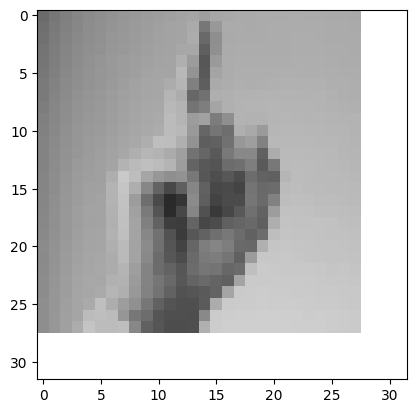

In [10]:
plt.imshow(X_train_rgb[0])

In [ ]:
def initiliaze_model_vgg16():
    
    #Initialising vgg16 
    classifier_vgg16 = VGG16(input_shape= (32,32,3),include_top=False,weights='imagenet')
    
    #Don't train existing weights for vgg16
    for layer in classifier_vgg16.layers:
        layer.trainable = False
    
    #Add other layers for pre-trained model    
    classifier = classifier_vgg16.output #head mode
    classifier = Flatten()(classifier) #adding layer of flatten
    classifier = Dense(units=256, activation='relu')(classifier)
    classifier = Dropout(0.6)(classifier)
    classifier = Dense(units=26, activation='softmax')(classifier)

    #Build & compile the model
    model = Model(inputs = classifier_vgg16.input , outputs = classifier)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model


In [ ]:
model = initiliaze_model_vgg16()
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0   

In [11]:
def initialize_model_resn50():
    #Initialising ResNet50 
    classifier_resnet = tflow.keras.applications.ResNet50(input_shape= (32,32,3),include_top=False,weights='imagenet')
    
    #don't train existing weights for resnet50
    for layer in classifier_resnet.layers:
        layer.trainable = False
     
    #Add the necessary layers for pre-trained model   
    classifier = classifier_resnet.output #head mode
    classifier = Flatten()(classifier) #adding layer of flatten
    classifier = Dense(units=512, activation='relu')(classifier)
    classifier = Dense(units=256, activation='relu')(classifier)
    classifier = Dropout(0.2)(classifier)
    classifier = Dense(units=26, activation='softmax')(classifier)

    #Build and compile the model
    model = Model(inputs = classifier_resnet.input , outputs = classifier)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model


In [12]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

y_train_ce = to_categorical(y_train, 26)
y_test_ce = to_categorical(y_test, 26)

X_train_scaled = X_train_rgb/255
X_test_scaled = X_test_rgb/255

X_train_f, X_val_f, y_train_f, y_val_f = train_test_split(X_train_scaled, y_train_ce, test_size=0.2, stratify=y_train_ce)
X_train_f.shape, X_val_f.shape, y_train_f.shape, y_val_f.shape

((21964, 32, 32, 3), (5491, 32, 32, 3), (21964, 26), (5491, 26))

In [ ]:
#fit the model and it will take some time to train
es = EarlyStopping(patience=3, restore_best_weights=True)
history = model.fit(X_train_f, y_train_f, epochs =15, batch_size = 64,validation_data=(X_val_f, y_val_f), callbacks=[es], verbose=1)

Epoch 1/15
344/344 [==============================] - 95s 274ms/step - loss: 1.7150 - accuracy: 0.4805 - val_loss: 0.8698 - val_accuracy: 0.7867
Epoch 2/15
344/344 [==============================] - 98s 286ms/step - loss: 0.8786 - accuracy: 0.7230 - val_loss: 0.5474 - val_accuracy: 0.8720
Epoch 3/15
344/344 [==============================] - 100s 290ms/step - loss: 0.6395 - accuracy: 0.8011 - val_loss: 0.4013 - val_accuracy: 0.8998
Epoch 4/15
344/344 [==============================] - 107s 312ms/step - loss: 0.4986 - accuracy: 0.8450 - val_loss: 0.2852 - val_accuracy: 0.9297
Epoch 5/15
344/344 [==============================] - 106s 309ms/step - loss: 0.3989 - accuracy: 0.8798 - val_loss: 0.2266 - val_accuracy: 0.9479
Epoch 6/15
344/344 [==============================] - 100s 290ms/step - loss: 0.3316 - accuracy: 0.9027 - val_loss: 0.1754 - val_accuracy: 0.9601
Epoch 7/15
344/344 [==============================] - 110s 319ms/step - loss: 0.2812 - accuracy: 0.9147 - val_loss: 0.1446 - v

In [13]:
def plot_loss_accuracy(history, suptitle):
    # Setting figures
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(13,4))
    # Create the plots
    ax1.plot(history.history['loss'])
    ax1.plot(history.history['val_loss'])
    ax2.plot(history.history['accuracy'])
    ax2.plot(history.history['val_accuracy'])
    # Set titles and labels
    ax1.set_title('Model loss')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')
    ax2.set_title('Accuracy')
    ax2.set_ylabel('Accuracy')
    ax2.set_xlabel('Epoch')
    # Set limits for y-axes
    ax1.set_ylim(ymin=0, ymax=3)
    ax2.set_ylim(ymin=0, ymax=1)

    # Generate legends
    ax1.legend(['Train', 'Validation'], loc='best')
    ax2.legend(['Train', 'Validation'], loc='best')
    # Show grids
    ax1.grid(axis="x",linewidth=0.5)
    ax1.grid(axis="y",linewidth=0.5)
    ax2.grid(axis="x",linewidth=0.5)
    ax2.grid(axis="y",linewidth=0.5)
    
    # Set supertitle
    plt.suptitle(suptitle)
    plt.show()
    
    return

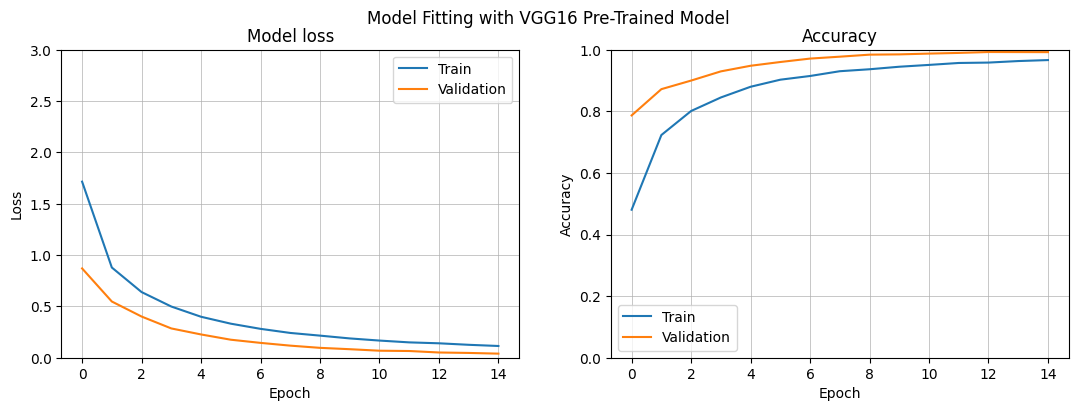

In [ ]:
plot_loss_accuracy(history, "Model Fitting with VGG16 Pre-Trained Model")

In [ ]:
score_vgg16 = model.evaluate(X_test_scaled, y_test_ce, verbose=1)
score_vgg16

225/225 [==============================] - 24s 106ms/step - loss: 0.2219 - accuracy: 0.9221


[0.2218780368566513, 0.9220579862594604]

In [20]:
#fit the model and it will take some time to train
es = EarlyStopping(patience=10, restore_best_weights=True)
model2 = initialize_model_resn50()
history2 = model2.fit(X_train_f, y_train_f, epochs=100, batch_size=64,validation_data=(X_val_f, y_val_f), callbacks=[es], verbose=1)

Epoch 1/100
344/344 [==============================] - 12s 22ms/step - loss: 2.9086 - accuracy: 0.1319 - val_loss: 2.4286 - val_accuracy: 0.2637
Epoch 2/100
344/344 [==============================] - 6s 18ms/step - loss: 2.2661 - accuracy: 0.2946 - val_loss: 2.0435 - val_accuracy: 0.3670
Epoch 3/100
344/344 [==============================] - 6s 16ms/step - loss: 1.9407 - accuracy: 0.3800 - val_loss: 1.7405 - val_accuracy: 0.4462
Epoch 4/100
344/344 [==============================] - 6s 18ms/step - loss: 1.7037 - accuracy: 0.4412 - val_loss: 1.4490 - val_accuracy: 0.5325
Epoch 5/100
344/344 [==============================] - 6s 17ms/step - loss: 1.4861 - accuracy: 0.5036 - val_loss: 1.3499 - val_accuracy: 0.5631
Epoch 6/100
344/344 [==============================] - 6s 17ms/step - loss: 1.3449 - accuracy: 0.5449 - val_loss: 1.2917 - val_accuracy: 0.5677
Epoch 7/100
344/344 [==============================] - 6s 18ms/step - loss: 1.2178 - accuracy: 0.5796 - val_loss: 1.1009 - val_accuracy

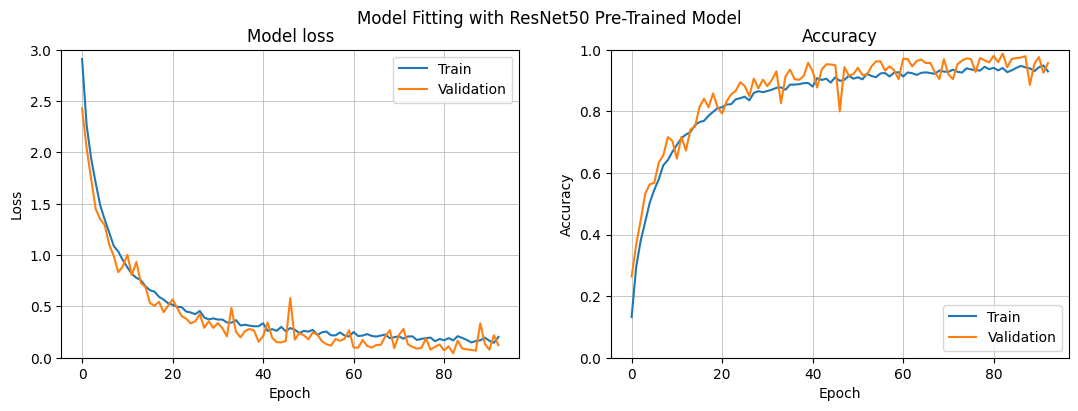

In [21]:
plot_loss_accuracy(history2, "Model Fitting with ResNet50 Pre-Trained Model")

In [22]:
score_resnet50 = model2.evaluate(X_test_scaled, y_test_ce, verbose=1)
score_resnet50

225/225 [==============================] - 3s 11ms/step - loss: 0.9139 - accuracy: 0.7893


[0.913853108882904, 0.7893195748329163]

In [23]:
# models.save_model(model, "transfer_models/model_vgg16_v1")
models.save_model(model2, "transfer_models/model_resnet50_v1")

In [ ]:
model = models.load_model("transfer_models/model_vgg16_v1")
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0   

In [ ]:
y_pred = model.predict(X_test_scaled)

225/225 [==============================] - 26s 117ms/step


In [ ]:
np.argmax(y_pred[0])

7

In [ ]:
%load_ext autoreload
%autoreload 

from transfer_learning import Transfer_Model

model = Transfer_Model()
model.predict('raw_data/test/sign_mnist_test_v01.csv')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
1/1 [==============================] - 0s 153ms/step


'v'

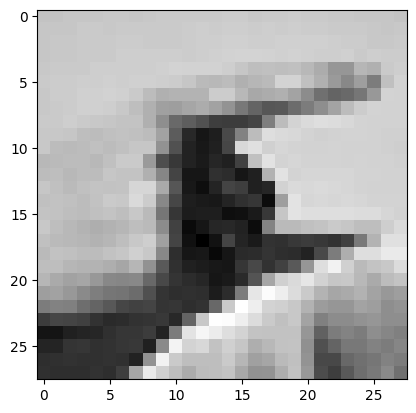

In [ ]:
pre = pd.read_csv('raw_data/test/sign_mnist_test_v01.csv', header=None)
plt.imshow(np.array(pre).reshape(28,28), cmap='gray')